In [0]:
import numpy as np
from random import shuffle
import pandas as pd

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1u1lLjj0mhhkxD3Bb4koXODqccQCla7bc'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('164_FACET.txt.csv')
#print('Downloaded content "{}"'.format(downloaded.GetContentString()))

In [3]:
facet = pd.read_csv('164_FACET.txt.csv')
facet.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,StudyName,ExportDate,Name,Age,Gender,StimulusName,SlideType,EventSource,Timestamp,...,RIGHT_EYE_MEDIAL Y,RIGHT_EYE_PUPIL X,RIGHT_EYE_PUPIL Y,RIGHT_EYE_LATERAL X,RIGHT_EYE_LATERAL Y,NOSE_TIP X,NOSE_TIP Y,LiveMarker,KeyStroke,MarkerText
0,0,MT430PN56164_DAY2,20150206,MT430PN56164_DAY2,20,FEMALE,Emotient_Baseline,TestImage,Emotient FACET,1423050113148,...,187.4306,322.3363,187.7792,343.4303,188.2750,277.6389,233.4232,NaN,NaN,NaN
1,1,MT430PN56164_DAY2,20150206,MT430PN56164_DAY2,20,FEMALE,Emotient_Baseline,TestImage,Emotient FACET,1423050113507,...,187.0614,322.6771,186.7172,343.1914,187.5230,279.1686,233.1206,NaN,NaN,NaN
2,2,MT430PN56164_DAY2,20150206,MT430PN56164_DAY2,20,FEMALE,Emotient_Baseline,TestImage,Emotient FACET,1423050114107,...,187.6148,321.9025,187.7366,343.4475,188.4239,278.4001,233.4976,NaN,NaN,NaN
3,3,MT430PN56164_DAY2,20150206,MT430PN56164_DAY2,20,FEMALE,Emotient_Baseline,TestImage,Emotient FACET,1423050114111,...,186.8495,322.8433,186.4361,343.3334,187.4559,278.6552,233.3093,NaN,NaN,NaN
4,4,MT430PN56164_DAY2,20150206,MT430PN56164_DAY2,20,FEMALE,Emotient_Baseline,TestImage,Emotient FACET,1423050114213,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
from sklearn.preprocessing import LabelEncoder

In [0]:
au1 = list(facet.columns).index('AU1 Evidence')
au28 = list(facet.columns).index('AU28 Evidence')
agent_action = facet[['AgentAction']].fillna('NaN').apply(LabelEncoder().fit_transform)
action_detail = facet[['ActionDetail']].fillna('NaN').apply(LabelEncoder().fit_transform)
X = pd.concat([agent_action,action_detail,facet.iloc[:,au1:au28+1]],axis=1).dropna(axis=0,how='any')

In [6]:
Y = facet[['Neutral Evidence']].iloc[X.index,:]
Y.head()

,Neutral Evidence
0,0.735853
1,0.930342
2,0.942179
3,0.839142
5,0.926964


In [7]:
print(Y)

        Neutral Evidence
0               0.735853
1               0.930342
2               0.942179
3               0.839142
5               0.926964
7               0.945954
8               1.031546
10              0.950788
12              0.743426
14              0.769630
15              0.728352
17              0.716344
19              0.601153
21              0.714271
23              0.665412
24              0.726972
26              0.750156
27              0.629075
29              0.782597
30              0.794664
32              0.799400
33              0.754224
35              0.811402
36              0.778631
38              0.825434
39              0.792000
41              0.733906
42              0.716892
44              0.732409
45              0.679810
...                  ...
327294          0.995894
327296          1.072486
327297          0.957542
327299          1.013245
327300          1.124823
327302          0.917931
327303          1.030135
327305          0.924657


In [0]:
Y = Y.apply(axis=1,func=lambda row: [1 if x>=0 else 0 for x in row.tolist()])

In [9]:
Y.iloc[:,0].sum()

188509

In [0]:
#train_input = []
#X2.apply(axis=1, func=lambda row: train_input.append([[cell] for cell in row.tolist()]))
#train_input = X2

In [0]:
#train_input[0]

In [0]:
#train_output = []
#Y2[['Joy Evidence']].apply(axis=1, func=lambda row: train_output.append(convert_to_vector(row)))

In [0]:
NUM_EXAMPLES = int(0.65*X.shape[0])
test_input = X[NUM_EXAMPLES:]
test_output = Y[NUM_EXAMPLES:]

train_input = X[:NUM_EXAMPLES]
train_output = Y[:NUM_EXAMPLES]

In [14]:
print(X.shape)
print(Y.shape)

(217031, 21)
(217031, 1)


In [0]:
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.layers import LSTM,Dense,Dropout,Masking
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix

In [0]:
X_train,X_test = np.array(train_input),np.array(test_input)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [0]:
Y_train,Y_test = np.array(train_output),np.array(test_output)

In [0]:
def build_fit_predict_lstm(X_train,Y_train,X_test,Y_test,epoch):
  rnnmodel = Sequential()
  #rnnmodel.add(LSTM(22,input_shape=(1,21),return_sequences=True))
  #rnnmodel.add(LSTM(22,input_shape=(1,21),return_sequences=True))
  rnnmodel.add(LSTM(22,input_shape=(1,21)))
  #rnnmodel.add(Dropout(0.1))
  rnnmodel.add(Dense(1,activation='sigmoid'))
  rnnmodel.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  rnnmodel.fit(X_train,Y_train,epochs=epoch,batch_size=1000,verbose=0)
  # Predict classes and probabilities
  Y_pred = rnnmodel.predict_classes(X_test, batch_size=1000)
  Y_prob = rnnmodel.predict(X_test, batch_size=1000)
  a_score = accuracy_score(Y_test,Y_pred)
  p_score = precision_score(Y_test,Y_pred)
  r_score = recall_score(Y_test,Y_pred)
  c_matrix = confusion_matrix(Y_test,Y_pred)
  print(c_matrix)
  return a_score,p_score,r_score
  

In [26]:
epochs,accuracy_scores,precision_scores,recall_scores = [],[],[],[]
for i in range(5,100,5):
  a_score, p_score, r_score = build_fit_predict_lstm(X_train,Y_train,X_test,Y_test,i)
  print("Epoch - ",i,"\t","Accuracy Score = ",a_score,"\t","Precision Score = ",p_score,"\t","Recall Score = ",r_score,"\n\n")
  accuracy_scores.append(a_score)
  precision_scores.append(p_score)
  recall_scores.append(r_score)
  epochs.append(i)



[[ 5445  2053]
 [ 4472 63991]]
Epoch -  5 	 Accuracy Score =  0.914100656916049 	 Precision Score =  0.9689146629519714 	 Recall Score =  0.9346800461563181 


[[ 5635  1863]
 [ 5169 63294]]
Epoch -  10 	 Accuracy Score =  0.907426179223549 	 Precision Score =  0.9714075233666375 	 Recall Score =  0.9244993646203059 


[[ 5763  1735]
 [ 5316 63147]]
Epoch -  15 	 Accuracy Score =  0.9071760508682087 	 Precision Score =  0.973259147375235 	 Recall Score =  0.9223522194470005 


[[ 5604  1894]
 [ 5084 63379]]
Epoch -  20 	 Accuracy Score =  0.9081370703387265 	 Precision Score =  0.9709834081473198 	 Recall Score =  0.9257409111490879 


[[ 5606  1892]
 [ 4791 63672]]
Epoch -  25 	 Accuracy Score =  0.9120206421716407 	 Precision Score =  0.9711427002623391 	 Recall Score =  0.930020595065948 


[[ 5577  1921]
 [ 4789 63674]]
Epoch -  30 	 Accuracy Score =  0.911665196614052 	 Precision Score =  0.9707142312676271 	 Recall Score =  0.9300498079254488 


[[ 5702  1796]
 [ 5758 62705]]
Epo

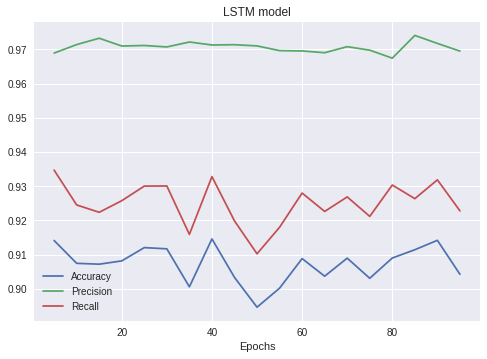

In [27]:
import matplotlib.pyplot as plt
plt.plot(epochs,accuracy_scores)
plt.plot(epochs,precision_scores)
plt.plot(epochs,recall_scores)
plt.legend(['Accuracy','Precision','Recall'])
plt.xlabel('Epochs')
plt.title('LSTM model')
plt.show()

In [29]:
print(max(accuracy_scores))
print(max(precision_scores))
print(max(recall_scores))

0.9128368504890667
0.9757090293380222
0.9344609497100623


In [55]:
#Running for all the emotions at epoch = 5
emotion_columns = ['Joy Evidence',
                   'Anger Evidence',
                   'Surprise Evidence',
                   'Fear Evidence',
                   'Contempt Evidence',
                   'Disgust Evidence',
                   'Sadness Evidence',
                   'Confusion Evidence',
                   'Frustration Evidence',
                   'Neutral Evidence',
                   'Positive Evidence',
                   'Negative Evidence']

emotion_accuracy_scores,emotion_precision_scores,emotion_recall_scores = [],[],[]

for y_column in emotion_columns:
  output = facet[[y_column]].iloc[X.index,:]
  output = output.apply(axis=1,func=lambda row: [1 if x>=0 else 0 for x in row.tolist()])
  test_output = Y[NUM_EXAMPLES:]
  train_output = Y[:NUM_EXAMPLES]
  y_train,y_test = np.array(train_output),np.array(test_output)
  print(y_column.split()[0] + ' - ')
  a_score, p_score, r_score = build_fit_predict_lstm(X_train,y_train,X_test,y_test,epoch=5)
  #print("Accuracy Score = ",a_score,"\t","Precision Score = ",p_score,"\t","Recall Score = ",r_score,"\n\n")
  emotion_accuracy_scores.append(a_score)
  emotion_precision_scores.append(p_score)
  emotion_recall_scores.append(r_score)
  
  

Joy - 
[[ 5371  2127]
 [ 5155 63308]]
Anger - 
[[ 5498  2000]
 [ 5686 62777]]
Surprise - 
[[ 5394  2104]
 [ 4873 63590]]
Fear - 
[[ 5389  2109]
 [ 5459 63004]]
Contempt - 
[[ 5264  2234]
 [ 4665 63798]]
Disgust - 
[[ 5391  2107]
 [ 5401 63062]]
Sadness - 
[[ 5582  1916]
 [ 5970 62493]]
Confusion - 
[[ 5443  2055]
 [ 5039 63424]]
Frustration - 
[[ 5274  2224]
 [ 4840 63623]]
Neutral - 
[[ 5551  1947]
 [ 5763 62700]]
Positive - 
[[ 5321  2177]
 [ 5056 63407]]
Negative - 
[[ 5348  2150]
 [ 5156 63307]]


In [45]:
emotion_columns

['Joy Evidence',
 'Anger Evidence',
 'Surprise Evidence',
 'Fear Evidence',
 'Contempt Evidence',
 'Disgust Evidence',
 'Sadness Evidence',
 'Confusion Evidence',
 'Frustration Evidence',
 'Neutral Evidence',
 'Positive Evidence',
 'Negative Evidence']

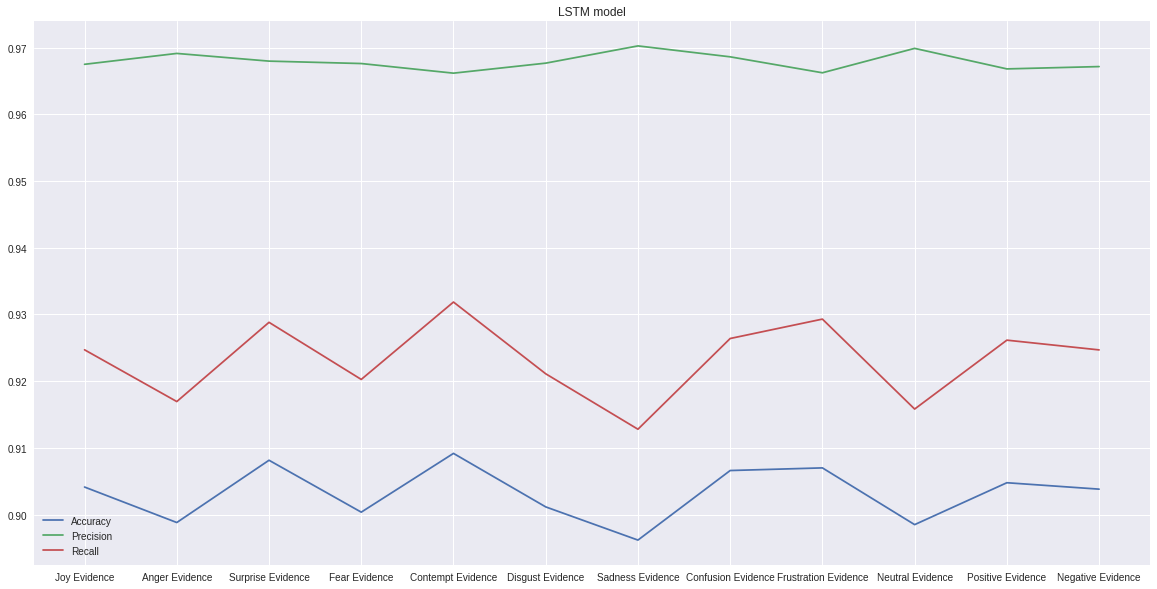

In [57]:
plt.figure(figsize=(20,10))
plt.plot(emotion_accuracy_scores)
plt.plot(emotion_precision_scores)
plt.plot(emotion_recall_scores)
plt.legend(['Accuracy','Precision','Recall'])
#plt.xlabel('Emotions')
plt.xticks(range(len(emotion_columns)),emotion_columns)
plt.title('LSTM model')
plt.show()

In [0]:
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,explained_variance_score

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.35, random_state=123)

In [23]:
xg_model = xgboost.XGBClassifier(n_estimators=100, learning_rate=0.1, gamma=0.1, subsample=1, colsample_bytree=1, max_depth=5)
xg_model.fit(X_train, y_train)
y_xg_predict = xg_model.predict(X_test)
y_train_predict=xg_model.predict(X_train)
acc=accuracy_score(y_test, y_xg_predict)
pre = precision_score(y_test,y_xg_predict)
rec =recall_score(y_test,y_xg_predict)
print("*********")
print("Accuracy:            "+str(acc))
print("Precision:        "+str(pre))
print("Recall: "+str(rec))
print("*********")

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


*********
Accuracy:            0.9637313884756652
Precision:        0.9758700626204239
Recall: 0.9825404283051181
*********


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [24]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(X_train, y_train)
y_lr_predict = LR.predict(X_test)
acc =accuracy_score(y_test, y_lr_predict)
pre =precision_score(y_test, y_lr_predict)
rec =recall_score(y_test, y_lr_predict)
print("*********")
print("Accuracy:            "+str(acc))
print("Precision:        "+str(pre))
print("Recall: "+str(rec))
print("*********")

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*********
Accuracy:            0.9360197996340227
Precision:        0.9527682711824229
Recall: 0.9746593716372896
*********
